# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
count = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    count = count+1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(count)

Total score (averaged over agents) this episode: 0.06399999856948853
1001


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### this section create model class

In [7]:
# create neural network policy and optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a neural net that outputs actions, sigma for each action and state value
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    
    # initialize layers
    def __init__(self, s_size=33, h_size=64, a_size=4):
        super(Policy, self).__init__()

        
        self.fc1 = nn.Linear(s_size, h_size)
#         self.bn1 = nn.BatchNorm1d(h_size)
        self.fc2 = nn.Linear(h_size, h_size)
#         self.bn2 = nn.BatchNorm1d(h_size)
        
        self.fc_critic1 = nn.Linear(s_size, h_size)
        self.fc_critic2 = nn.Linear(h_size, h_size)
        
        self.fc_sig1 = nn.Linear(s_size, h_size)
        self.fc_sig2 = nn.Linear(h_size, h_size)
        
        self.fc_action = nn.Linear(h_size, a_size)
        self.fc_value = nn.Linear(h_size, 1)
        self.fc_sigma = nn.Linear(h_size, a_size)
        
#         self.std = nn.Parameter(torch.ones(1, a_size))
        # Standard deviations approximated seperately
#         self.register_parameter('log_sigma', None)
#         self.sigma = nn.Parameter(torch.ones(1, action_size)*0.5, requires_grad=True)
                
    # forward function for calculating mu, sigma and value
    def forward(self, state):
        
        # mu output
        x = (F.relu(self.fc1(state)))
        x = (F.relu(self.fc2(x)))
        # action outputs
#         mu = (self.fc_action(x))
        mu = F.tanh(self.fc_action(x))
    
        # sigma output
        x2 = (F.relu(self.fc_sig1(state)))
        x2 = (F.relu(self.fc_sig2(x2)))
#         sigma = F.softplus(self.fc_sigma(x))
        sigma = F.sigmoid(self.fc_sigma(x2))
#         sigma = F.softplus(self.sigma).expand(mu.size())

        # critic value output
        x3 = F.relu(self.fc_critic1(state))
        x3 = F.relu(self.fc_critic2(x3))
        value = self.fc_value(x3)
        
        return mu, sigma, value
    
    
# run your own policy!
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

### this section define the function which generate trajectories

In [8]:
## build function that collect history data
from torch.distributions import Normal

def collect_trajectories(env, policy, tmax=200, num_agents=20, state_size=33, action_size=4, epi_search = 1.0):
    action_list = []
    state_list = []
    reward_list = []
    prob_list = []
    value_list = []
    
    # reset environment
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=True)[brain_name] 
    
    # get starting state
    state_current = env_info.vector_observations
    
    for t in range(tmax):
        # append current state to state list
        state_list.append(state_current)
        
        # map current state to mu_current, sigma_current
        state_current = torch.from_numpy(state_current).to(torch.float).to(device)
        mu_current, sigma_current, value_current = policy(state_current)
        
        # create distribution object
#         sigma_rollout = torch.ones_like(sigma_current)*epi_search
        dist = Normal(mu_current, sigma_current+1e-8)
        
        # get action
        act_current = dist.sample()
        act_current = torch.clamp(act_current, -1, 1)
        
        # calculate probabiliy of act_current
        prob = torch.exp(dist.log_prob(act_current))
        prob = prob.cpu().detach().numpy()
        
        # get reward, done flag and state_next
        act_current = act_current.cpu().detach().numpy()
        env_info = env.step(act_current)[brain_name]
        reward = env_info.rewards
        done = env_info.local_done 
        state_next = env_info.vector_observations
        
        # append state_current, act_current, reward and done flag into list
        action_list.append(act_current)
        reward_list.append(reward)
        prob_list.append(prob)        
        value_list.append(value_current.cpu().detach().numpy())
        
        # assign state_next to state_current
        state_current = state_next
        
        if any(done):
            break
    
    # transfer to numpy array from list
    state_list = np.array(state_list)
    action_list = np.array(action_list)
    prob_list = np.array(prob_list)
    value_list = np.array(value_list)
    reward_list = np.array(reward_list)
    reward_list = np.expand_dims(reward_list, -1)
    
    
    return state_list, action_list, prob_list, reward_list, value_list
            

In [9]:
# test cell
# states, actions, probs, rewards, values = collect_trajectories(env, policy)

### this section define the function that calculate loss

In [10]:
# helper funtion for normalize rewards and values
def normalization(rewards):
    rewards_mean = np.mean(rewards, 1, keepdims=True)
    rewards_std = np.std(rewards, 1, keepdims=True)+1e-10
    rewards_normalize = (rewards-rewards_mean)/rewards_std
    
    return rewards_normalize

# helper function for calculate discounted future rewards, td_error, advantage and monte-carlo advantage
def Cal_GAE(rewards, values, reward_discount = 0.99, adv_discount = 0.95): 
    # create variables for storing cumulative rewards
    reward_future = np.zeros(np.shape(rewards))
    reward_future_pre = np.zeros(np.shape(rewards[0]))
    
    # create variables for storing cumulative advantage estimation
    advantage = np.zeros(np.shape(rewards))
    advantage_pre = np.zeros(np.shape(rewards[0]))
    
    # create variables for storing td_error
    td_error = np.zeros(np.shape(rewards))
    
    # loop in reversed order
    for i in reversed(range(len(rewards))):
        
        # calculate cumulative reward
        reward_future[i] = rewards[i] + reward_discount*reward_future_pre
        reward_future_pre = reward_future[i]
        
        # calculate td_error
        if i == len(rewards)-1:
            td_error[i] = rewards[i] - values[i]
        else:
            td_error[i] = rewards[i] + reward_discount*values[i+1] - values[i]
            
        # calculate advantage
        advantage[i] = td_error[i] + reward_discount*adv_discount*advantage_pre
        advantage_pre = advantage[i]
        
        # calculate monte-carlo advantage
        mc_error = reward_future-values

    return reward_future, td_error, advantage, mc_error

In [11]:
# test cell
# reward_future, td_error, advantage, mc_error = Cal_GAE(rewards, values)

In [12]:
# function for calculating loss
def clipped_surrogate(policy, states, actions, prob_old, reward_future, td_error, advantage, mc_error, 
                      epsilon=0.2, beta=0.01, mse_w = 0.5, mode = "advantage"):
       
    # transfer reward_future, td_error and advantage to tensor
    reward_future = torch.tensor(reward_future, dtype=torch.float, device=device)
    mc_error = torch.tensor(mc_error, dtype=torch.float, device=device)
    td_error = torch.tensor(td_error, dtype=torch.float, device=device)
    advantage = torch.tensor(advantage, dtype=torch.float, device=device)
    
    # calculate mu, sigma and state value
    states = torch.tensor(states, dtype=torch.float, device=device)
    mu, sigma, value = policy(states)
    
    # calculate current action probability
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    dist_training = Normal(mu, sigma)
    prob_new = torch.exp(dist_training.log_prob(actions))
    
    # calculate probability ratio = prob_new/prob_old
    prob_old = torch.tensor(prob_old, dtype=torch.float, device=device)
    ratio = prob_new/prob_old

    # calculate clipped loss function
    ratio_clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    if mode == "MC":
        clipped_surrogate_loss = -torch.mean(torch.min(ratio*mc_error, ratio_clip*mc_error))
    elif mode == "TD":
        clipped_surrogate_loss = -torch.mean(torch.min(ratio*td_error, ratio_clip*td_error))
    else:
        clipped_surrogate_loss = -torch.mean(torch.min(ratio*advantage, ratio_clip*advantage))

    # calculate MSE loss value 
    mse_loss = torch.mean((reward_future - value).pow(2))
    
    # calculate entropy regularization term
    entropy_loss = -torch.mean(dist_training.entropy())
    
    # total loss
    total_loss = clipped_surrogate_loss + mse_w*mse_loss + beta*entropy_loss
    
    return total_loss, clipped_surrogate_loss, mse_loss, entropy_loss

In [13]:
# test cell
# L1, L2, L3, L4 = clipped_surrogate(policy, states, actions, probs, reward_future, td_error, advantage, mc_error)

### this section is the main training loop

In [15]:
# hyperparameters
discount_reward = .99
discount_advantage = 0.8
epsilon = 0.2
epsilon_decay = 0.998
beta = 0.01
beta_decay = 0.99
mse_w = 0.5
epi_search = 1.0

In [16]:
# training config
episode = 250
tmax = 1000
step = 20
minibatch_size = 20
load_flag = False
shuffle_flag = True
normalization_flag = True
GAE_mode = "GAE"
saving_flag = True

In [17]:
# import package that include function to keep workspace alive
import os
import requests
import time
import matplotlib.pyplot as plt
from collections import deque

# main training function
from parallelEnv import parallelEnv
# keep track of how long training takes

# load policy if needed
if load_flag == True:
    policy = torch.load('PPO_Reacher.policy')

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# keep track of progress
mean_rewards = []
loss_clip_his = []
loss_mse_his = []
loss_entropy_his = []
mean_rewards_window = deque(maxlen=100)  # last 100 scores
mean_rewards_window_his = []

# start time tracker time
old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for e in range(episode):
    
    # check current time and old time difference, if difference is too big, send request to keep workspace alive
    if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
    
    # collect trajectories
    states, actions, probs, rewards, values = collect_trajectories(env, policy, tmax, num_agents, 
                                                               state_size, action_size, epi_search)
    
    # helper function for calculate discounted future rewards, td_error, advantage and monte-carlo advantage
    reward_future, td_error, advantage, mc_error = Cal_GAE(rewards, values, 
                                                           discount_reward, discount_advantage)
    
    # normalize advantage estimations
    if normalization_flag == True:
        td_error = normalization(td_error)
        advantage = normalization(advantage)
        mc_error = normalization(mc_error)
    
    
    # declare variable to store total rewards for each episode                   
    total_rewards = np.sum(rewards, axis=0)
    total_rewards = total_rewards.squeeze(-1)
    
    
    # create temporary variable to accumulate loss for each epoch
    L_clip_temp = 0
    L_mse_temp = 0
    L_entropy_temm = 0
    
    # loop through each step
    for _ in range(step):
        
        # random shuffle indices for training
        if shuffle_flag == True:
            indices = np.arange(len(states))
            np.random.shuffle(indices)
            
        # calculate SGD_epoch based on (length of data)/minibatch
        SGD_epoch = len(states)//minibatch_size
                
        for i in range(SGD_epoch):

            # retreive minibatch indices
            ind_start = i*minibatch_size
            ind_end = min([(i+1)*minibatch_size,len(states)])
            indices_train = indices[ind_start:ind_end]

            # retreive minibatch data
            states_mini = states[indices_train]
            actions_mini = actions[indices_train]
            probs_old_mini = probs[indices_train]
            reward_future_mini = reward_future[indices_train]
            td_error_mini = td_error[indices_train]
            advantage_mini = advantage[indices_train]
            mc_error_mini = mc_error[indices_train]
                        
            # calculate loss function and keep track of clip loss, mse loss and entropy loss
            L, L_clip, L_mse, L_entropy = clipped_surrogate(policy, states_mini, actions_mini, probs_old_mini, 
                                                            reward_future_mini, td_error_mini, advantage_mini, mc_error_mini,
                                                            epsilon, beta, mse_w, GAE_mode)
            
            # accumulate loss history
            L_clip_temp = L_clip_temp + L_clip
            L_mse_temp = L_mse_temp + L_mse
            L_entropy_temm = L_entropy_temm + L_entropy

            # optimize neural network parameters
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L, L_clip, L_mse, L_entropy

    # the clipping parameter reduces as time goes on
    epsilon*=epsilon_decay
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=beta_decay
#     if beta<1e-4:
#         beta = 1e-4
    
    # epi_search update
#     epi_search = epi_search*0.995
#     if epi_search<0.001:
#         epi_search = 0.001
    
    # get the average reward and loss of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    mean_rewards_window.append(np.mean(total_rewards))
    mean_rewards_window_his.append(np.mean(mean_rewards_window))
    loss_clip_his.append(L_clip_temp/step/SGD_epoch)
    loss_mse_his.append(L_mse_temp/step/SGD_epoch)
    loss_entropy_his.append(L_entropy_temm/step/SGD_epoch)
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
    if np.mean(mean_rewards_window)>=30.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e-100, 
                                                                                     np.mean(mean_rewards_window)))
        break
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


Episode: 20, score: 4.319000
[ 7.34999984  4.19999991  3.47999992  5.06999989  5.36999988  2.80999994
  2.03999995  5.14999988  3.98999991  4.4099999   4.4899999   2.93999993
  5.18999988  4.09999991  4.87999989  6.12999986  3.76999992  2.21999995
  3.62999992  5.15999988]


Episode: 40, score: 15.502000
[  7.97999982  20.81999953  20.18999955  20.93999953   8.62999981
   6.43999986  12.64999972  11.67999974  25.74999942  23.77999947
  20.86999953   8.64999981  12.72999972  10.11999977  25.34999943
  15.29999966  19.74999956  16.14999964   9.68999978  12.56999972]


Episode: 60, score: 26.845999
[ 28.36999937  27.40999939  23.93999946  26.35999941  30.38999932
  16.34999963  32.61999927  12.57999972  25.17999944  39.50999912
  21.67999952  30.26999932  27.88999938  23.79999947  28.26999937
  30.57999932  24.71999945  32.21999928  28.03999937  26.7399994 ]


Episode: 80, score: 29.962499
[ 32.66999927  31.71999929  32.38999928  25.91999942  27.60999938
   9.78999978  37.29999917  33.00999926  32.15999928  29.00999935
  32.26999928  32.53999927  32.41999928  25.99999942  30.49999932
  32.28999928  28.97999935  29.61999934  32.01999928  31.02999931]


Episode: 100, score: 35.348499
[ 38.65999914  34.48999923  37.59999916  34.83999922  33.84999924
  38.28999914  34.64999923  37.56999916  27.57999938  37.62999916
  38.95999913  36.12999919  39.07999913  31.4799993   30.96999931
  34.02999924  37.48999916  35.04999922  34.24999923  34.36999923]


Episode: 120, score: 33.497499
[ 36.85999918  33.25999926  31.82999929  27.65999938  33.41999925
  39.38999912  38.87999913  39.03999913  27.11999939  32.80999927
  30.87999931  28.99999935  34.12999924  37.85999915  30.97999931
  34.70999922  37.16999917  38.30999914  25.22999944  31.4099993 ]



Environment solved in 34 episodes!	Average Score: 30.14


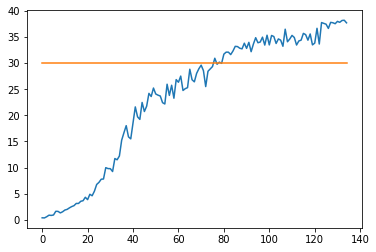

In [18]:
plt.plot(mean_rewards)
plt.plot(np.ones(len(mean_rewards))*30.0)

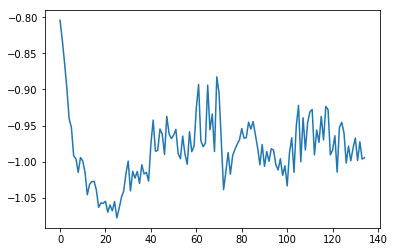

In [19]:
plt.plot(loss_entropy_his)

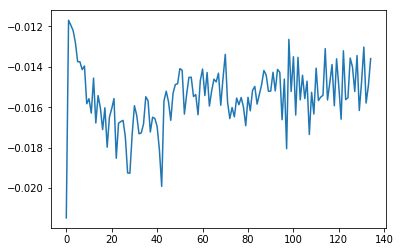

In [20]:
plt.plot(loss_clip_his)

In [21]:
# save current policy
if saving_flag == True:
    torch.save(policy, 'PPO_Reacher.policy')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
env.close()